<a href="https://colab.research.google.com/github/saiKelkar/Fast.ai/blob/main/01_intro.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Step 1: Download images of birds and non-birds

In [4]:
# To install duckduckgo_search
!pip install -Uqq duckduckgo_search

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 30.2 MB/s eta 0:00:00


In [5]:
from duckduckgo_search import DDGS
from fastcore.all import *

def search_images(keywords, max_images = 200): return L(DDGS().images(keywords, max_results=max_images)).itemgot('image')

In [6]:
urls = search_images('bird photos', max_images=1)
urls[0]

'https://images.pexels.com/photos/326900/pexels-photo-326900.jpeg?cs=srgb&dl=wood-flight-bird-326900.jpg&fm=jpg'

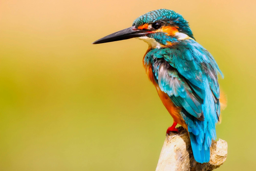

In [7]:
from fastdownload import download_url
dest = 'bird.jpg'
download_url(urls[0], dest, show_progress=False)

from fastai.vision.all import *
im = Image.open(dest)
im.to_thumb(256, 256)

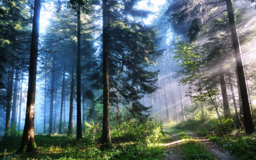

In [8]:
download_url(search_images('forest photos', max_images=1)[0], 'forest.jpg', show_progress=False)
Image.open('forest.jpg').to_thumb(256, 256)

In [9]:
# Downloading 200 examples of each 'bird' and 'forest' photos, and save each group of photos to a different folder
searches = 'forest', 'bird'
path = Path('bird_or_not')
from time import sleep

for o in searches:
  dest = (path/o)
  dest.mkdir(exist_ok=True, parents=True)
  download_images(dest, urls=search_images(f'{o} photos'))
  sleep(10) # Pause between searches to avoid over-loading server
  download_images(dest, urls=search_images(f'{o} sun photos'))
  sleep(10)
  download_images(dest, urls=search_images(f'{o} shade photos'))
  sleep(10)
  resize_images(path/o, max_size=400, dest=path/o)

/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3570: UserWarning: image file could not be identified because AVIF support not installed
  warnings.warn(message)
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3570: UserWarning: image file could not be identified because AVIF support not installed
  warnings.warn(message)
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3570: UserWarning: image file could not be identified because AVIF support not installed
  warnings.warn(message)
/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3570: UserWarning: image file could not be identified because AVIF support not installed
  warnings.warn(message)
